# Analyse du ds 5 pour les 302

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

In [2]:
from repytex.tools.evaluation import Evaluation

In [3]:
db = "../recopytex.db"
conn = sqlite3.connect(db)
c = conn.cursor()

In [4]:
tribe_name = "302"
tribe_id = c.execute("SELECT id from tribe WHERE tribe.name ==  ?", (tribe_name,)).fetchone()[0]
print(f"La tribu des {tribe_name} (id = {tribe_id})")

La tribu des 302 (id = 1)


In [5]:
evals = c.execute("SELECT id, name from eval WHERE eval.tribe_id == ?", (tribe_id,))
print("Liste des évaluations:")
for e in evals:
    print(f" - {e[1]} (id = {e[0]})")

Liste des évaluations:
 - DS1 mise en jambe (id = 1)
 - DS2 (id = 5)
 - Pyramide de pièces (id = 8)
 - DS3 (id = 10)
 - DM noel (id = 14)
 - DS4 (id = 16)
 - DNB blanc1 (id = 21)
 - DS5 (id = 29)
 - Téléphérique (id = 30)


In [81]:
ev_id = 29
ev = Evaluation.from_sqlite(ev_id, conn)
ev

<eval DS5 for 302>

## Il semble qu'il y est des doublons

In [82]:
q_sc_df = ev.sc_df.set_index("id")

In [83]:
q_sc_df.columns

Index(['question_id', 'student_id', 'value'], dtype='object')

In [84]:
q_sc_df.count()

question_id    2285
student_id     2285
value          2285
dtype: int64

In [85]:
qst_filtered = q_sc_df[q_sc_df.duplicated(['question_id', 'student_id'], keep='first')]
qst_filtered[['question_id', 'student_id']].head()

question_id  student_id
id                           
7917          302           1
7918          303           1
7919          304           1
7920          302           2
7921          303           2

In [86]:
qst_filtered.tail(1)

question_id  student_id value
id                                  
10616          327          26     2

In [87]:
q_sc_df[q_sc_df.duplicated(['question_id', 'student_id', 'value'], keep='last')].count()

question_id    1600
student_id     1600
value          1600
dtype: int64

In [88]:
len(q_sc_df["question_id"].unique())

26

In [89]:
len(q_sc_df["student_id"].unique())

25

In [90]:
26 * 25

650

Donc j'ai des notes qui sont differentes pour un même élève sur une même questions...

Je veux maintenant trouver ces notes.

In [91]:
gped_sc = q_sc_df.groupby(["student_id", "question_id"])['value'].apply(set)
gped_sc[gped_sc.apply(lambda x: len(x) != 1)].head()

student_id  question_id
10          310            {0, 1}
12          309            {1, 2}
13          311            {2, 3}
14          303            {2, 3}
16          313            {2, 3}
Name: value, dtype: object

On garde la dernière note enregistrée

In [92]:
def keep_last(df):
    return df.sort_index().tail(1)

In [93]:
gped_sc = q_sc_df.groupby(["student_id", "question_id"])['value'].apply(keep_last)
q_sc_df = gped_sc.reset_index().set_index("id")
q_sc_df.head()

student_id  question_id value
id                                 
8079           1          302     2
8080           1          303     2
8081           1          304     1
8484           1          305     3
8485           1          306     1

In [147]:
q_sc_df['fullname_st'] = q_sc_df[['name_st', 'surname_st']].apply(lambda x: " ".join(x), axis=1)

## Recalcul des notes et compétences

Jointure avec la dataframe sur les élèves

In [94]:
st_df = ev.s_df
st_df.columns = st_df.columns.map(lambda x: f"{x}_st" if 'id' not in x else x)
st_df.columns

Index(['id', 'name_st', 'surname_st', 'mail_st', 'commment_st', 'tribe_id'], dtype='object')

In [95]:
q_sc_df = q_sc_df.merge(st_df, left_on="student_id", right_on="id", suffixes=("", "_st"))
q_sc_df.head()

student_id  question_id value  id           name_st surname_st mail_st  \
0           1          302     2   1  ABDALLAH ALLAOUI  Taiassima           
1           1          303     2   1  ABDALLAH ALLAOUI  Taiassima           
2           1          304     1   1  ABDALLAH ALLAOUI  Taiassima           
3           1          305     3   1  ABDALLAH ALLAOUI  Taiassima           
4           1          306     1   1  ABDALLAH ALLAOUI  Taiassima           

  commment_st  tribe_id  
0        None         1  
1        None         1  
2        None         1  
3        None         1  
4        None         1

Jointure avec la dataframe sur les questions

In [96]:
q_df = ev.q_df
q_df.columns = q_df.columns.map(lambda x: f"{x}_q" if 'id' not in x else x)
q_df.columns

Index(['id', 'name_q', 'score_rate_q', 'is_leveled_q', 'exercise_id',
       'competence_q', 'domain_q', 'comment_q'],
      dtype='object')

In [97]:
q_sc_df = q_sc_df.merge(q_df, left_on="question_id", right_on="id", suffixes=("", "_q"))
q_sc_df.tail()

student_id  question_id value  id  name_st  surname_st mail_st  \
645          23          331     3  23  MOUSSRI      Bakari           
646          24          331     3  24     SAÏD    Fatoumia           
647          25          331     3  25  SAKOTRA   Claudiana           
648          26          331     3  26  TOUFAIL     Salahou           
649          76          331     3  76  Ibrahim  Chaharzade           

    commment_st  tribe_id  id_q name_q  score_rate_q  is_leveled_q  \
645        None         1   331                   10             1   
646        None         1   331                   10             1   
647        None         1   331                   10             1   
648        None         1   331                   10             1   
649        None         1   331                   10             1   

     exercise_id competence_q      domain_q                 comment_q  
645          102          Com  Présentation  Présentation de la copie  
646          102          Com  Présentation  Présentation de la copie  
647          102          Com  Présentation  Présentation de la copie  
648          102          Com  Présentation  Présentation de la copie  
649          102          Com  Présentation  Présentation de la copie

Calcul des notes

In [98]:
q_sc_df["value_no_dot"] = q_sc_df["value"].replace('.', 0)

In [99]:
q_sc_df["mark"] = q_sc_df["score_rate_q"] * q_sc_df["value_no_dot"] / 3

In [100]:
q_sc_df.columns

Index(['student_id', 'question_id', 'value', 'id', 'name_st', 'surname_st',
       'mail_st', 'commment_st', 'tribe_id', 'id_q', 'name_q', 'score_rate_q',
       'is_leveled_q', 'exercise_id', 'competence_q', 'domain_q', 'comment_q',
       'value_no_dot', 'mark'],
      dtype='object')

In [101]:
q_sc_df.groupby(['student_id', 'exercise_id'])[["score_rate_q", 'mark']].sum().head(10)

score_rate_q       mark
student_id exercise_id                         
1          95                     12   6.666667
           96                     10   5.333333
           97                     17   4.000000
           98                     18   4.000000
           99                     18   7.000000
           100                    15   1.000000
           102                    10  10.000000
2          95                     12   6.666667
           96                     10   4.666667
           97                     17   9.666667

Voila... j'ai les notes...

In [179]:
mark_df = q_sc_df.groupby(['fullname_st'])[["score_rate_q", 'mark']].sum()
mark_df

score_rate_q       mark
fullname_st                                         
ABDALLAH ALLAOUI Taiassima            100  38.000000
ADANI Ismou                           100  60.333333
AHAMADI Asbahati                      100  43.666667
AHAMADI OUSSENI Ansufiddine           100  25.000000
AHAMED Fayadhi                        100  31.666667
AHMED SAID Hadaïta                    100  62.000000
ALI MADI Anissa                       100  77.666667
ALI Raydel                            100  62.333333
ATTOUMANE ALI Fatima                  100  42.000000
BACHIROU Elzame                       100  21.666667
BINALI Zalida                         100  63.000000
BOINA Abdillah Mze Limassi            100  69.333333
BOUDRA Zaankidine                     100  35.666667
BOURA Kayssoiria                      100  44.000000
HALADI Asna                           100  68.666667
HALIDI Soibrata                       100  37.333333
HAMEDALY Doulkifly                    100  34.666667
IBRAHIM Nassur                        100  56.666667
Ibrahim Chaharzade                    100  50.333333
MOHAMED Nadia                         100  51.666667
MOUHOUDHOIRE Izak                     100  36.666667
MOUSSRI Bakari                        100  24.000000
SAKOTRA Claudiana                     100  52.666667
SAÏD Fatoumia                         100  58.333333
TOUFAIL Salahou                       100  56.000000

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f153c0b35f8>], dtype=object)

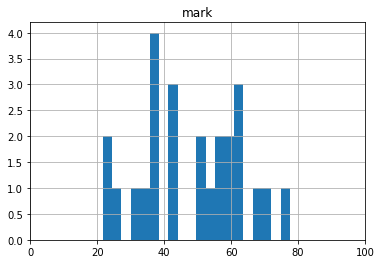

In [192]:
fig, ax = plt.subplots()
ax.set_xlim([0, 100])
mark_df.hist("mark",bins=20, ax=ax)

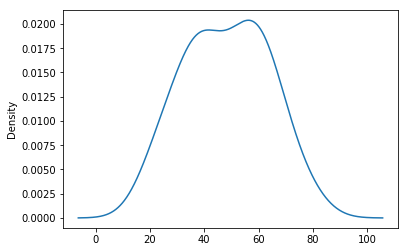

In [197]:
mark_df["mark"].plot.kde()

In [193]:
mark_df['mark'].describe()

count    25.000000
mean     48.133333
std      15.323064
min      21.666667
25%      36.666667
50%      50.333333
75%      60.333333
max      77.666667
Name: mark, dtype: float64

## Comparaison entre compétences brutes et coefficientés

In [110]:
q_sc_df.head()

student_id  question_id value  id           name_st   surname_st mail_st  \
0           1          302     2   1  ABDALLAH ALLAOUI    Taiassima           
1           2          302     2   2             ADANI        Ismou           
2           4          302     2   4           AHAMADI     Asbahati           
3           5          302     3   5   AHAMADI OUSSENI  Ansufiddine           
4           6          302     3   6            AHAMED      Fayadhi           

  commment_st  tribe_id  id_q name_q  score_rate_q  is_leveled_q  exercise_id  \
0        None         1   302                    4             1           95   
1        None         1   302                    4             1           95   
2        None         1   302                    4             1           95   
3        None         1   302                    4             1           95   
4        None         1   302                    4             1           95   

  competence_q domain_q                 comment_q  value_no_dot      mark  
0          Rep    Proba  Calculer une probabilité             2  2.666667  
1          Rep    Proba  Calculer une probabilité             2  2.666667  
2          Rep    Proba  Calculer une probabilité             2  2.666667  
3          Rep    Proba  Calculer une probabilité             3  4.000000  
4          Rep    Proba  Calculer une probabilité             3  4.000000

Bilan des compétences sans coefficients

In [141]:
def value_mean(df):
    df_ = df.replace(".", 0)
    return round(df_["value"].mean(), 0)

Bilan avec les coefficients

In [152]:
def mark_mean(df):
    df_ = df.replace(".", 0)
    mark_sum = df_["mark"].sum() * 3
    rate_sum = df_["score_rate_q"].sum()
    try:
        return round(mark_sum / rate_sum, 0)
    except ZeroDivisionError:
        return np.nan

Bilan des compétences

In [156]:
comp_value_df = q_sc_df.groupby(['fullname_st', "competence_q"]).apply(value_mean).unstack()

In [157]:
comp_mark_df = q_sc_df.groupby(['fullname_st', "competence_q"]).apply(mark_mean).unstack()

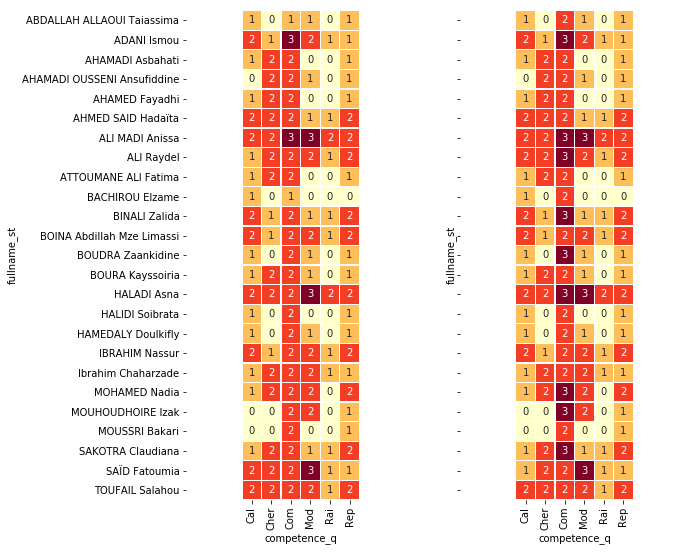

In [195]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9), sharey=True)
ax2.set_xlabel('')
sns.heatmap(comp_value_df,linewidths=0.2, annot=True, square=True, cbar=False, cmap="YlOrRd", ax=ax1)
sns.heatmap(comp_mark_df,linewidths=0.2, annot=True, square=True, cbar=False, cmap="YlOrRd", ax=ax2)